In [1]:
import spotchaos.syntheticSignals as sp

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import TimedAnimation
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pickle

import os
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr
from scipy.signal import argrelextrema, savgol_filter, find_peaks_cwt
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit

from pytisean import tiseano, tiseanio

from sklearn.neighbors import KDTree, BallTree
from scipy.spatial import KDTree as scipyKDTree

#%matplotlib inline

In [2]:
# Time series:
# 0. White noise
# 1. stationary GP time series
# 2. Simple periodic
# 3. KB88 R(t)
# 4. Rossler x, y, z
# 5. Transformed rossler u, v, w
# 6. Lorenz x, y, z

# and for each we have 3 baselines: TESS (perfect = 257062 data points), Kepler (perfect = 71422 data points), SPECULOOS (perfect = 44119 data points)
#                   and 4 versions: perfect, gapless+noisy, gappy+noiseless, realistic
# yielding 13*3*4 = 156 time series to analyze altogether. (But only 78 files, because the perfect and noisy versions are in the same file.)

# Need to choose:
# 1. time delay (Fraser & Swinney 1986)
# 2. embedding dimension (Cao 1997)
# and then calculate
# 1. correlation dimension (Kurths & Herzel 1987; investigate pytisean too. Look into Thelier window.)
# 2. Lyapunov spectrum (Wolf et al. 1985)
# 3. Lyapunov dimension (Kaplan-Yorke conjecture; see Eckmann & Ruelle 1985 eq 4.11).

# Expected results:
# 0. White noise should have no good choice of time delay; mutual info as a function of delay time should be flat.
# 1. Not sure!
# 2. Simple periodic and KB88 R(t) results should be similar to KB88 figures 9 and 10.
# 3. same
# 4. Rossler x, y, and z should yield time delay ~ 1/4*rossler_qp and embedding dimension of 3. Rossler z results should be worse than x and y.
# 5. Transformed Rossler u, v, and w should yield time delay ~1/4*transformed_rossler_qp and embedding dimension of 3. Variables should be about equally good.
# 6. Lorenz x, y, and z should yield time delay ~1/4*lorenz_qp and embedding dimension of 3. z dimension will be insensitive to wing symmetry.


In [3]:
folderpaths = ['4_rossler',
               '5_transformed_rossler',
               '6_lorenz']


In [4]:
def has_stepsize_one(it):
    return all(x2 - x1 == 1 for x1, x2 in zip(it[:-1], it[1:]))

4_rossler_x_speculoos_perfect.txt
[3 4 5 6]
sat_m is 3
4_rossler_y_speculoos_perfect.txt
[3 4 5 6]
sat_m is 3
4_rossler_z_speculoos_perfect.txt
[3 6]
sat_m is None
[3 6]
sat_m is None
sat_m is None
5_transformed_rossler_x_speculoos_perfect.txt
[3 4 5 6]
sat_m is 3
5_transformed_rossler_y_speculoos_perfect.txt
[3 4 5 6]
sat_m is 3
5_transformed_rossler_z_speculoos_perfect.txt
[3 4 5 6]
sat_m is 3
6_lorenz_x_speculoos_perfect.txt
[4 5 6]
sat_m is 4
6_lorenz_y_speculoos_perfect.txt
[4 5 6]
sat_m is 4
6_lorenz_z_speculoos_perfect.txt
[4 5 6]
sat_m is 4


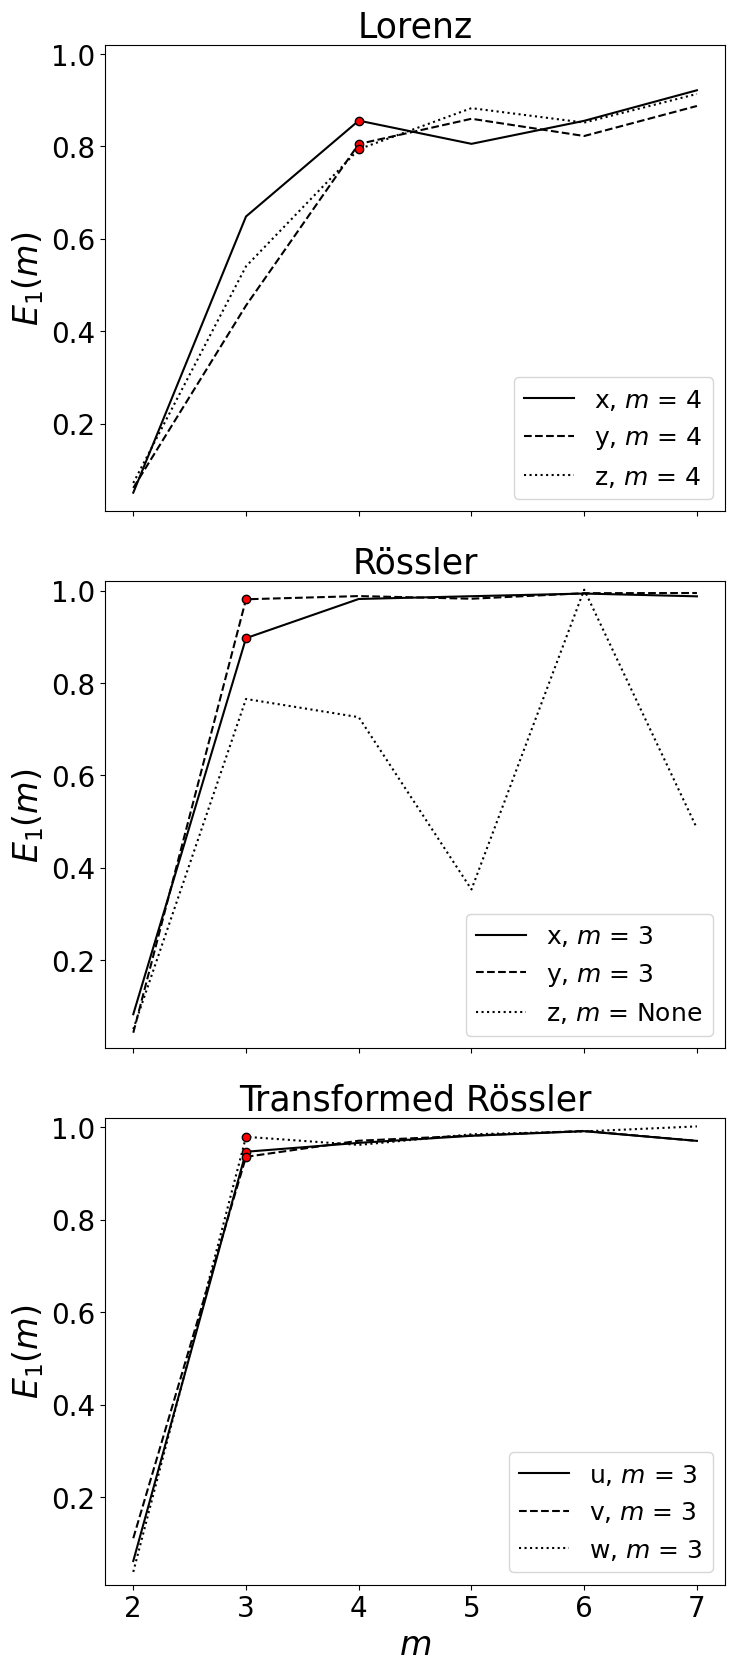

In [14]:
fig, axes = plt.subplots(3,1,figsize=(8,20),sharex=True)

for folder in folderpaths:
#for folder in ['6_lorenz','blah']:
    files = sorted(os.scandir("./data/{0}/".format(folder)), key=lambda e: e.name)
    for file in files:
        if ".txt" in file.name and "perfect" in file.name and "speculoos" in file.name:
            print(file.name)
            data = np.genfromtxt(file.path)
            
            if "0" in file.name:
                ts = data[:,2]

            else:
                ts = data[:,1]
                
            if "lorenz" in file.name and "_z_" not in file.name:
                QPmethod = "localMaxSep"
            elif "0" in file.name:
                QPmethod = "localMaxSep"
            else:
                QPmethod = "power"

            # choose time delay (Fraser & Swinney 1986)
            if "0" in file.name:
                mutInfo, bestTauIdx, qp = sp.FS86(time = data[:,0], timeSeries = ts, QPmethod=QPmethod, method="global_min", plot=False)
            else:
                mutInfo, bestTauIdx, qp = sp.FS86(time = data[:,0], timeSeries = ts, QPmethod=QPmethod, method="first_or_second_local_min", plot=False)


            E1_change_cutoff=0.2
            mMax = 6
            
            # choose embedding dimension (Cao 1997)
            E1, E2 = sp.cao97(timeSeries=ts, tau=bestTauIdx, mMax=mMax+2)
            percentChange_E1_i_ip1 = (E1[1:] - E1[0:-1])/E1[0:-1]
            percentChange_E1_i_ip2 = np.zeros_like(percentChange_E1_i_ip1)
            percentChange_E1_i_ip2[:-1] = (E1[2:] - E1[0:-2])/E1[0:-2]

            stableMask = (percentChange_E1_i_ip1 < E1_change_cutoff) & (percentChange_E1_i_ip2 < E1_change_cutoff)
            stableInds = np.arange(2,mMax+1)[stableMask]
            print(stableInds)
            
            if has_stepsize_one(stableInds): 
                sat_m = stableInds[0]
            else:
                sat_m = None
                print("sat_m is None")
                print(stableInds)
            
            print("sat_m is {0}".format(sat_m))

            if "_x_" in file.name:
                linestyle_ = '-'
                if 'transformed' not in file.name:
                    label_ = r'x, $m$ = {0}'.format(sat_m)
                else:
                    label_ = r'u, $m$ = {0}'.format(sat_m)
            elif "_y_" in file.name:
                linestyle_ = '--'
                if 'transformed' not in file.name:
                    label_ = r'y, $m$ = {0}'.format(sat_m)
                else:
                    label_ = r'v, $m$ = {0}'.format(sat_m)
            elif "_z_" in file.name:
                linestyle_ = ':'
                if 'transformed' not in file.name:
                    label_ = r'z, $m$ = {0}'.format(sat_m)
                else:
                    label_ = r'w, $m$ = {0}'.format(sat_m)
            
            if "lorenz" in file.name:
                axes[0].plot(np.arange(2,mMax+2), E1, color='k',ls=linestyle_,label=label_)
                axes[0].plot(sat_m, E1[sat_m-2], color='r',marker='o',mec='k')
                #axes[0].axvline(sat_m, color='#3772ff',ls=linestyle_)
            elif "4_rossler" in file.name:
                axes[1].plot(np.arange(2,mMax+2), E1, color='k',ls=linestyle_,label=label_)
                try:
                    #axes[1].axvline(sat_m, color='#3772ff',ls=linestyle_)
                    axes[1].plot(sat_m, E1[sat_m-2], color='r',marker='o',mec='k')
                except TypeError:
                    print("sat_m is {0}".format(sat_m))
            elif "5_transformed" in file.name:
                axes[2].plot(np.arange(2,mMax+2), E1, color='k',ls=linestyle_,label=label_)
                axes[2].plot(sat_m, E1[sat_m-2], color='r',marker='o',mec='k')
                #axes[2].axvline(sat_m, color='#3772ff',ls=linestyle_)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel(r"$E_1(m)$",fontsize=24)
    ax.legend(loc='lower right',fontsize=18)
    ax.set_xlim(1.75,7.25)
    ax.set_ylim(0.01,1.02)
axes[2].set_xlabel(r"$m$",fontsize=24)

axes[0].set_title("Lorenz",fontsize=25)
axes[1].set_title("Rössler",fontsize=25)
axes[2].set_title("Transformed Rössler",fontsize=25)

plt.subplots_adjust(hspace=0.15)     
plt.savefig("./cao1997demo.pdf",bbox_inches="tight")
plt.show()
            